# Mixup / Label smoothing

In [27]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
#export
from exp.nb_10 import *

In [29]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [30]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

## Mixup

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=226)

### What is mixup?

As the name kind of suggests, the authors of the [mixup article](https://arxiv.org/abs/1710.09412) propose to train the model on a mix of the pictures of the training set. Let's say we're on CIFAR10 for instance, then instead of feeding the model the raw images, we take two (which could be in the same class or not) and do a linear combination of them: in terms of tensor it's
``` python
new_image = t * image1 + (1-t) * image2
```
where t is a float between 0 and 1. Then the target we assign to that image is the same combination of the original targets:
``` python
new_target = t * target1 + (1-t) * target2
```
assuming your targets are one-hot encoded (which isn't the case in pytorch usually). And that's as simple as this.

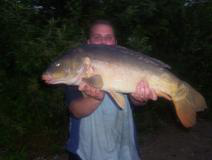

In [31]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

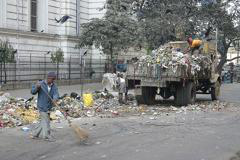

In [32]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

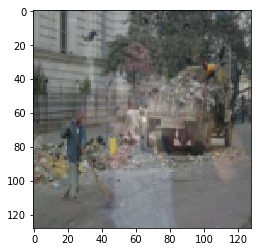

In [33]:
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[4000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

French horn or tench? The right answer is 70% french horn and 30% tench ;)

### Implementation

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=490)

The implementation relies on something called the *beta distribution* which in turns uses something which Jeremy still finds mildly terrifying called the *gamma function*. To get over his fears, Jeremy reminds himself that *gamma* is just a factorial function that (kinda) interpolates nice and smoothly to non-integers too. How it does that exactly isn't important...

In [34]:
# PyTorch has a log-gamma but not a gamma, so we'll create one
Γ = lambda x: x.lgamma().exp()

NB: If you see math symbols you don't know you can google them like this: [Γ function](https://www.google.com/search?q=Γ+function).

If you're not used to typing unicode symbols, on Mac type <kbd>ctrl</kbd>-<kbd>cmd</kbd>-<kbd>space</kbd> to bring up a searchable emoji box. On Linux you can use the [compose key](https://help.ubuntu.com/community/ComposeKey). On Windows you can also use a compose key, but you first need to install [WinCompose](https://github.com/samhocevar/wincompose). By default the <kbd>compose</kbd> key is the right-hand <kbd>Alt</kbd> key.

You can search for symbol names in WinCompose. The greek letters are generally <kbd>compose</kbd>-<kbd>\*</kbd>-<kbd>letter</kbd> (where *letter* is, for instance, <kbd>a</kbd> to get greek α alpha).

In [35]:
facts = [math.factorial(i) for i in range(7)]

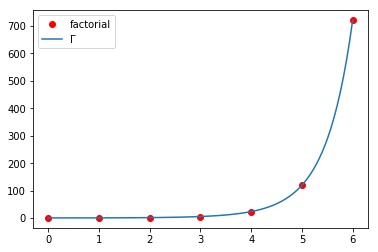

In [36]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial','Γ']);

In [37]:
torch.linspace(0,0.9,10)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

In the original article, the authors suggested three things:
 1. Create two separate dataloaders and draw a batch from each at every iteration to mix them up
 2. Draw a t value following a beta distribution with a parameter α (0.4 is suggested in their article)
 3. Mix up the two batches with the same value t.
 4. Use one-hot encoded targets

Why the beta distribution with the same parameters α? Well it looks like this:

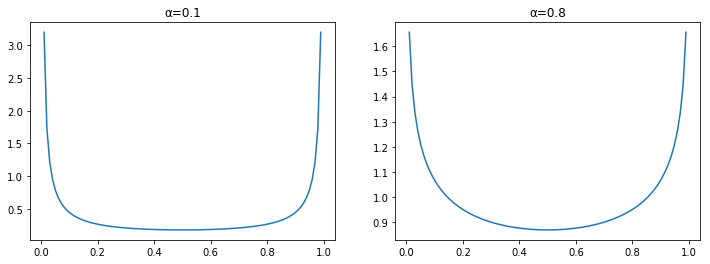

In [38]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor(α)
#     y = (x.pow(α-1) * (1-x).pow(α-1)) / (gamma_func(α ** 2) / gamma_func(α))
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

With a low `α`, we pick values close to 0. and 1. with a high probability, and the values in the middle  all have the same kind of probability. With a greater `α`, 0. and 1. get a lower probability .

While the approach above works very well, it's not the fastest way we can do this. The main point that slows down this process is wanting two different batches at every iteration (which means loading twice the amount of images and applying to them the other data augmentation function). To avoid this slow down, we can be a little smarter and mixup a batch with a shuffled version of itself (this way the images mixed up are still different). This was a trick suggested in the MixUp paper.

Then pytorch was very careful to avoid one-hot encoding targets when it could, so it seems a bit of a drag to undo this. Fortunately for us, if the loss is a classic cross-entropy, we have
```python
loss(output, new_target) = t * loss(output, target1) + (1-t) * loss(output, target2)
```
so we won't one-hot encode anything and just compute those two losses then do the linear combination.

Using the same parameter t for the whole batch also seemed a bit inefficient. In our experiments, we noticed that the model can train faster if we draw a different t for every image in the batch (both options get to the same result in terms of accuracy, it's just that one arrives there more slowly).
The last trick we have to apply with this is that there can be some duplicates with this strategy: let's say or shuffle say to mix image0 with image1 then image1 with image0, and that we draw t=0.1 for the first, and t=0.9 for the second. Then
```python
image0 * 0.1 + shuffle0 * (1-0.1) = image0 * 0.1 + image1 * 0.9
image1 * 0.9 + shuffle1 * (1-0.9) = image1 * 0.9 + image0 * 0.1
```
will be the same. Of course, we have to be a bit unlucky but in practice, we saw there was a drop in accuracy by using this without removing those near-duplicates. To avoid them, the tricks is to replace the vector of parameters we drew by
``` python
t = max(t, 1-t)
```
The beta distribution with the two parameters equal is symmetric in any case, and this way we insure that the biggest coefficient is always near the first image (the non-shuffled batch).


In `Mixup` we have handle loss functions that have an attribute `reduction` (like `nn.CrossEntropy()`). To deal with the `reduction=None` with various types of loss function without modifying the actual loss function outside of the scope we need to perform those operations with no reduction, we create a context manager:

In [39]:
#export
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)    

Then we can use it in `MixUp`:

In [40]:
#export
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss    

In [41]:
#export
class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [42]:
nfs = [32,64,128,256,512]

In [43]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [44]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

In [45]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [46]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.059836,0.339383,1.642205,0.452000,00:17


Questions: How does softmax interact with all this? Should we jump straight from mixup to inference?

## Label smoothing

Another regularization technique that's often used is label smoothing. It's designed to make the model a little bit less certain of it's decision by changing a little bit its target: instead of wanting to predict 1 for the correct class and 0 for all the others, we ask it to predict `1-ε` for the correct class and `ε` for all the others, with `ε` a (small) positive number and N the number of classes. This can be written as:

$$loss = (1-ε) ce(i) + ε \sum ce(j) / N$$

where `ce(x)` is cross-entropy of `x` (i.e. $-\log(p_{x})$), and `i` is the correct class. This can be coded in a loss function:

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1121)

In [47]:
#export
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

Note: we implement the various reduction attributes so that it plays nicely with MixUp after.

In [48]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [49]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs, loss_func=LabelSmoothingCrossEntropy())

In [50]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.968174,0.373507,1.833972,0.416000,00:16


And we can check our loss function `reduction` attribute hasn't changed outside of the training loop:

In [51]:
assert learn.loss_func.reduction == 'mean'

## Export

In [52]:
!./notebook2script.py 10b_mixup_label_smoothing.ipynb

Traceback (most recent call last):
  File "./notebook2script.py", line 3, in <module>
    import json,fire,re
ModuleNotFoundError: No module named 'fire'
